In [1]:
import itertools, copy
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

In [2]:
counters = [count_kmers_proteome(human, k) for k in range(1, 6)]

In [3]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
aas = ''.join(sorted(df0['seq']))
print(len(aas), aas)

20 ACDEFGHIKLMNPQRSTVWY


In [4]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
df0 = df0.set_index('seq')
humanaaprobdict = np.log(df0['freq']).to_dict()
humanaaprobdict

df1 = counter_to_df(counters[1], norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = np.log(count).to_dict()

In [5]:
df2 = counter_to_df(counters[2], norm=False)
df2['aa12'] = [s[:2] for s in df2['seq']]
df2['aa3'] = [s[2] for s in df2['seq']]
count = df2.pivot(columns='aa12', index='aa3')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humantripletprobdict = np.log(count).to_dict()

In [6]:
h = copy.deepcopy(humanaaprobdict)
J0 = dict(zip(aminoacids, [dict(zip(aminoacids, np.zeros(len(aminoacids))))]*len(aminoacids)))
Jk = [J0, copy.deepcopy(J0)]

In [7]:
Z = np.exp(scipy.special.logsumexp([-energy_ising(s, h, Jk) for s in itertools.product(aminoacids, repeat=3)]))

In [8]:
np.exp(-energy_ising('ACL', h, Jk))/Z

0.00016062054578543723

In [9]:
print(np.exp(loglikelihood_independent('ACL', humanaaprobdict)))
print(np.exp(loglikelihood_mc('ACL', humanaaprobdict, humandoubletprobdict)))
print(np.exp(loglikelihood_triplet('ACL', humanaaprobdict, humandoubletprobdict, humantripletprobdict)))

0.0001606189778362446
0.00013991001867381708
0.0001452302456227127


In [10]:
df1 = counter_to_df(counters[1])
df1 = df1[~df1['seq'].str.contains('U|B|X|Z')]
df1 = df1.set_index('seq')

In [11]:
dfgap1 = counter_to_df(count_kmers_proteome(human, 2, gap=1))
dfgap1 = dfgap1[~dfgap1['seq'].str.contains('U|B|X|Z')]
dfgap1 = dfgap1.set_index('seq')

In [12]:
dfgap2 = counter_to_df(count_kmers_proteome(human, 2, gap=2))
dfgap2 = dfgap2[~dfgap2['seq'].str.contains('U|B|X|Z')]
dfgap2 = dfgap2.set_index('seq')

In [15]:
def fit_ising(f1, f2s, niter=1, nmcmc=1e6, epsilon=0.1, Jk=None):
    h = np.log(f1['freq']).to_dict()
    aas_arr = np.array(list(aminoacids))
    if Jk is None:
        J0 = np.zeros((len(aminoacids), len(aminoacids)))
        J0 = pd.DataFrame(np.asarray(J0), index=list(aminoacids), columns=list(aminoacids)).to_dict()
        Jk = [J0]
        for gap in range(1, len(f2s)):
            Jk.append(copy.deepcopy(J0))
    for i in range(niter):
        jump = lambda x: ''.join(np.random.choice(aas_arr, size=6))
        x0 = jump(None)
        samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, nmcmc)
        for gap in range(len(f2s)):
            m = f2s[gap].merge(counter_to_df(count_kmers_iterable(samples, 2, gap=gap)), left_index=True, right_on='seq')
            m['logfold'] = np.log(m['freq_x']/m['freq_y'])
            print(i, gap, np.mean(np.abs(m['logfold'])))
            for idx, row in m.iterrows():
                logfold = row['logfold']
                aa1 = row['seq'][0]
                aa2 = row['seq'][1]
                Jk[gap][aa1][aa2] += logfold * epsilon
    return h, Jk

In [83]:
h, Jk = fit_ising(df0, [df1, dfgap1, dfgap2], nmcmc=1e5, niter=30, epsilon=0.2)

0 0 0.11706752039432258
0 1 0.10024265186724339
0 2 0.10712739297337932
1 0 0.09981067933629768
1 1 0.09375070209660157
1 2 0.09424118722780413
2 0 0.08346590189800736
2 1 0.08190425455668958
2 2 0.08969863176096647
3 0 0.08240682010373196
3 1 0.07136576997084579
3 2 0.08300827714021572
4 0 0.07004288933966857
4 1 0.0710959998483191
4 2 0.07275202189701985
5 0 0.06634825953834815
5 1 0.06378753953416046
5 2 0.07761536184563694
6 0 0.06539025637065829
6 1 0.06972813754257995
6 2 0.07702086132624833
7 0 0.06154560509932292
7 1 0.07065306603371325
7 2 0.0760498334596897
8 0 0.056852173785027056
8 1 0.06290104684786325
8 2 0.07558480672162324
9 0 0.06057715489014006
9 1 0.06479111179596601
9 2 0.07400426054969969
10 0 0.05458888344441995
10 1 0.06602199885634003
10 2 0.07103185758205956
11 0 0.05861859200603951
11 1 0.0675915230220828
11 2 0.07784247650622889
12 0 0.06250727115648988
12 1 0.07021377157291947
12 2 0.07943256615290946
13 0 0.05962113201415196
13 1 0.06386989408636104
13 2 0.

In [84]:
jump = lambda x: ''.join(np.random.choice(list(aminoacids), size=8))
x0 = jump(0)
samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, 1e6)

0.014686917977685298

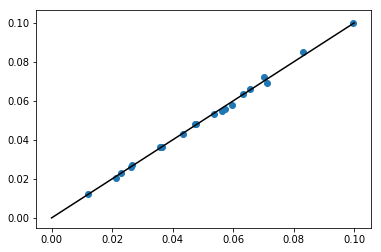

In [85]:
dfm0 = df0.merge(counter_to_df(count_kmers_iterable(samples, 1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.1)
plt.plot(x, x, 'k')
plt.scatter(dfm0['freq_x'], dfm0['freq_y'])
dfm0['logfold'] = np.log(dfm0['freq_x']/dfm0['freq_y'])
np.abs(dfm0['logfold']).mean()

0.03217669383902013

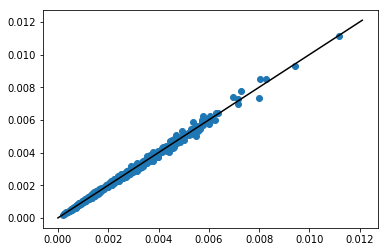

In [86]:
dfm1 = df1.merge(counter_to_df(count_kmers_iterable(samples, 2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfm1['freq_x'], dfm1['freq_y'])
dfm1['logfold'] = np.log(dfm1['freq_x']/dfm1['freq_y'])
np.abs(dfm1['logfold']).mean()

0.03364039869827224

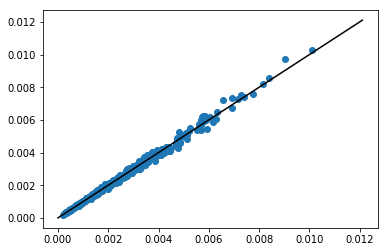

In [87]:
dfmgap1 = dfgap1.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap1['freq_x'], dfmgap1['freq_y'])
dfmgap1['logfold'] = np.log(dfmgap1['freq_x']/dfmgap1['freq_y'])
np.abs(dfmgap1['logfold']).mean()

0.03603338929256267

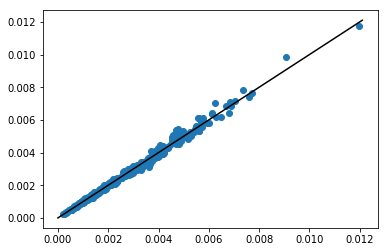

In [88]:
dfmgap2 = dfgap2.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap2['freq_x'], dfmgap2['freq_y'])
dfmgap2['logfold'] = np.log(dfmgap2['freq_x']/dfmgap2['freq_y'])
np.abs(dfmgap2['logfold']).mean()

In [89]:
dfJk = [pd.DataFrame.from_dict(J) for J in Jk]

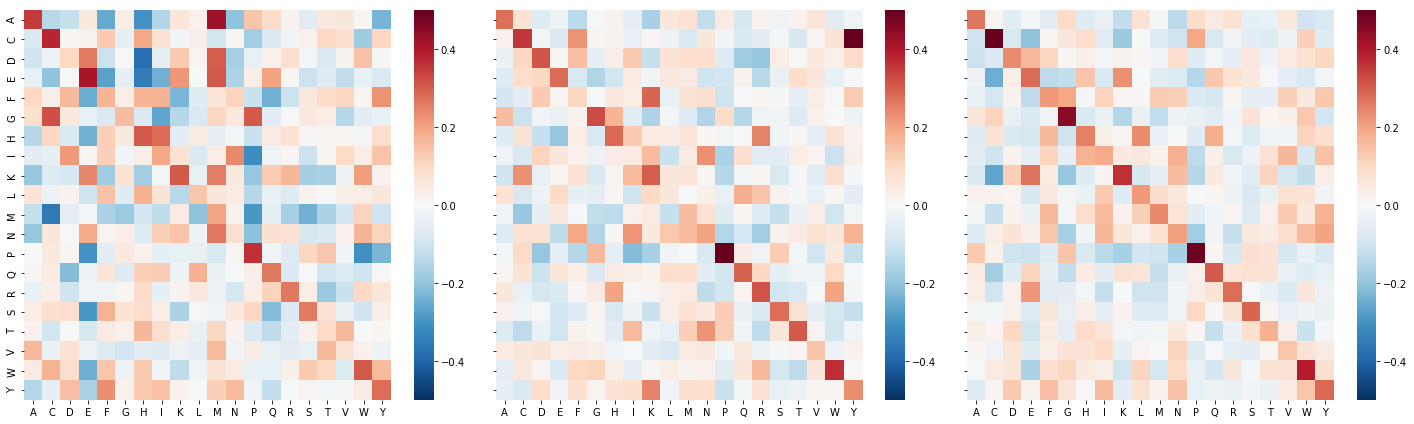

In [90]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=len(dfJk), sharex=True, sharey=True)
for i, dfJ in enumerate(dfJk):
    sns.heatmap(dfJ, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=axes[i])
fig.tight_layout()

In [91]:
k = 4
#kmers = list(itertools.product(aminoacids, repeat=k))
df = counter_to_df(count_kmers_proteome(human, k))
df = df[~df['seq'].str.contains('U|B|X|Z')]
df = df.set_index('seq')
kmers = df.index
exp = np.array([float(df.loc[''.join(s)]) for s in kmers])
Z = np.exp(scipy.special.logsumexp([-energy_ising(s, h, Jk) for s in itertools.product(aminoacids, repeat=k)]))
ising = np.exp([-energy_ising(s, h, Jk) for s in kmers])/Z
tri = np.array([np.exp(loglikelihood_triplet(s, humanaaprobdict,
                                             humandoubletprobdict,
                                             humantripletprobdict)) for s in kmers])
mc = np.array([np.exp(loglikelihood_mc(s, humanaaprobdict,
                                          humandoubletprobdict)) for s in kmers])
ind = np.array([np.exp(loglikelihood_independent(s, humanaaprobdict)) for s in kmers])

(0.939688111252018, 0.9262848547691673, 0.8821731898433343, 0.8232060016090637)

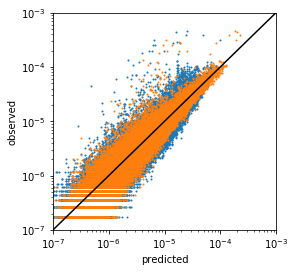

In [94]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(ind, exp, s=1)
#plt.scatter(mc, exp, s=1)
plt.scatter(ising, exp, s=1)
x = np.logspace(-7, -3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot(x, x, 'k')
plt.xlim(min(x), max(x))
plt.ylim(min(x), max(x))
plt.xscale('log')
plt.yscale('log')
np.corrcoef(tri, exp)[1, 0], np.corrcoef(ising, exp)[1, 0], np.corrcoef(mc, exp)[1, 0], np.corrcoef(ind, exp)[1, 0]